In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import performance_metrics
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras import Sequential, layers
from keras.layers import Dense, Dropout
from pickle import load

In [2]:
# raw_data = pd.read_csv(r"../data/processed_data/undersampled_train.csv", index_col=0)
raw_data = pd.read_csv(r"../data/processed_data/complete_data.csv", index_col=0)

In [3]:
x = raw_data.drop(["TARGET"], axis=1)
y = raw_data.filter(["TARGET"], axis=1)

scaler = scaler = load(open(r"scaler.pkl", "rb"))  # MinMaxScaler often made values = 0.0, which = lost features in training
x_scaled = scaler.transform(x)
y = y.values  # we dont need to scale our binary classification

# x_scaled = x_scaled.reshape(x_scaled.shape[0], x_scaled.shape[1], )  # data needs to be 3D for a CNN

x_scaled.shape, y.shape

((565372, 202), (565372, 1))

In [4]:
# split the dataset into 50/50 - 50 for tuning, 50 for kfold validation
split = 0.5

hp_x, hp_y = x_scaled[:int(len(x_scaled) * split)], y[:int(len(y) * split)] # hyperparameter set
kf_x, kf_y = x_scaled[int(len(x_scaled) * split):], y[int(len(y) * split):] # kfold set


In [5]:
def model_builder(hp):
    model = Sequential()

    # input layer
    model.add(Dense(units=x_scaled.shape[1], input_shape=(x_scaled.shape[1],)))

    # let the model decide how many layers it wants to have
    for i in range(hp.Int("num_dense_layers", min_value=2, max_value=5, step=1)):
        model.add(
            Dropout(hp.Float("dropout_" + str(i), min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            Dense(
                units=hp.Int("layer_" + str(i), min_value=32, max_value=1024, step=64),
                activation=hp.Choice("act_" + str(i), ["relu", "sigmoid"]),
            )
        )

    # output shape of the model the same as the number of features
    model.add(
        Dense((1), activation="sigmoid"),
    )

    # compile the model
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(), "accuracy"],
    )

    return model


In [6]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=2)

In [7]:
project = "BayOpt_v1.04 - 50pct"

tuner = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective("accuracy", direction="max"),
    max_trials=20, # I could stop it earlier, or even let it run forever but, my computer isn't powerful enough
    directory=f"../logs/{project}",
    project_name=project,
)


In [8]:
tuner.search(
    hp_x,
    hp_y,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[earlyStop],
)


Trial 17 Complete [00h 07m 41s]
accuracy: 0.9542644619941711

Best accuracy So Far: 0.957412838935852
Total elapsed time: 01h 11m 07s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
5                 |5                 |num_dense_layers
0.1               |0.3               |dropout_0
96                |608               |layer_0
sigmoid           |relu              |act_0
0.4               |0                 |dropout_1
864               |544               |layer_1
sigmoid           |relu              |act_1
0.1               |0.001             |learning_rate
0.4               |0                 |dropout_2
32                |32                |layer_2
sigmoid           |relu              |act_2
0                 |0                 |dropout_3
928               |32                |layer_3
relu              |relu              |act_3
0                 |0                 |dropout_4
800               |32                |layer_4
sigmoid           |relu         

KeyboardInterrupt: 

In [9]:
hpModel = tuner.get_best_models()[0]
hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

hpModel.summary(), hyperparameters.values

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 202)               41006     
                                                                 
 dropout (Dropout)           (None, 202)               0         
                                                                 
 dense_1 (Dense)             (None, 608)               123424    
                                                                 
 dropout_1 (Dropout)         (None, 608)               0         
                                                                 
 dense_2 (Dense)             (None, 544)               331296    
                                                                 
 dropout_2 (Dropout)         (None, 544)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

(None,
 {'num_dense_layers': 5,
  'dropout_0': 0.30000000000000004,
  'layer_0': 608,
  'act_0': 'relu',
  'dropout_1': 0.0,
  'layer_1': 544,
  'act_1': 'relu',
  'learning_rate': 0.001,
  'dropout_2': 0.0,
  'layer_2': 32,
  'act_2': 'relu',
  'dropout_3': 0.0,
  'layer_3': 32,
  'act_3': 'relu',
  'dropout_4': 0.0,
  'layer_4': 32,
  'act_4': 'relu'})

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=663)

results = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1", "auc", "fpr", "fnr"])
results.index.name = "Model"

counter = 1
confusion_matrix_sum = None

for train_index, test_index in kfold.split(kf_x):
    x_train, x_test = kf_x[train_index], kf_x[test_index]
    y_train, y_test = kf_y[train_index], kf_y[test_index]
    
    # fit model to train set
    model = hpModel.fit(kf_x, kf_y, epochs=10, batch_size=64, callbacks=earlyStop)
    y_pred = hpModel.predict(x_test)
    
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
    
    # calculate confusion matrix, and append data for later visualisation
    cm = confusion_matrix(y_test, y_pred_binary)
    fpr = cm[0][1] / cm.sum()
    fnr = cm[1][0] / cm.sum()
    
    if confusion_matrix_sum is None:
        confusion_matrix_sum = cm
    else:
        confusion_matrix_sum += cm
    
    # calculate metrics and append to dataframe
    metrics = performance_metrics.metrics(y_test, y_pred_binary) 
    accuracy, precision, recall, f1, auc_result = metrics.calculate_metrics()
    results.loc[counter] = [accuracy, precision, recall, f1, auc_result, fpr, fnr]
    
    print(f"Fold {counter} completed")
    counter += 1

# calculate the average over all models
results.loc["Average"] = [results.accuracy.mean(),
                        results.precision.mean(),
                        results.recall.mean(),
                        results.f1.mean(),
                        results.auc.mean(),
                        results.fpr.mean(),
                        results.fnr.mean()]

Epoch 1/10
4417/4417 [==============================] - 37s 8ms/step - loss: 0.0500 - auc: 0.9973 - accuracy: 0.9827
Epoch 2/10
4417/4417 [==============================] - 35s 8ms/step - loss: 0.0502 - auc: 0.9973 - accuracy: 0.9828
Epoch 3/10
4417/4417 [==============================] - 35s 8ms/step - loss: 0.0491 - auc: 0.9975 - accuracy: 0.9830
Epoch 4/10
4417/4417 [==============================] - 36s 8ms/step - loss: 0.0473 - auc: 0.9976 - accuracy: 0.9833
Epoch 5/10
4417/4417 [==============================] - 36s 8ms/step - loss: 0.0472 - auc: 0.9976 - accuracy: 0.9837
Epoch 6/10
4417/4417 [==============================] - 36s 8ms/step - loss: 0.0459 - auc: 0.9977 - accuracy: 0.9841
Epoch 7/10
4417/4417 [==============================] - 36s 8ms/step - loss: 0.0457 - auc: 0.9978 - accuracy: 0.9840
Epoch 8/10
4417/4417 [==============================] - 40s 9ms/step - loss: 0.0445 - auc: 0.9979 - accuracy: 0.9846
Epoch 9/10
4417/4417 [==============================] - 37s 8ms/

In [43]:
results.round(4) * 100

# save to csv for easy viewing
# results.to_csv(r"../results/neural-network-scores-1.04")

,accuracy,precision,recall,f1,auc,fpr,fnr
Model,,,,,,,
1,98.53,99.57,97.48,98.52,98.53,0.21,1.26
2,98.74,99.76,97.74,98.74,98.75,0.12,1.14
3,98.85,99.48,98.21,98.84,98.85,0.26,0.89
4,98.87,99.55,98.19,98.86,98.87,0.22,0.91
5,98.72,99.83,97.59,98.70,98.71,0.08,1.20
Average,98.74,99.64,97.84,98.73,98.74,0.18,1.08


In [39]:
# save confusion matrix 
cm_df = pd.DataFrame(confusion_matrix_sum)
# cm_df.to_csv(r"../results/neural-network-cmdata-1.04")

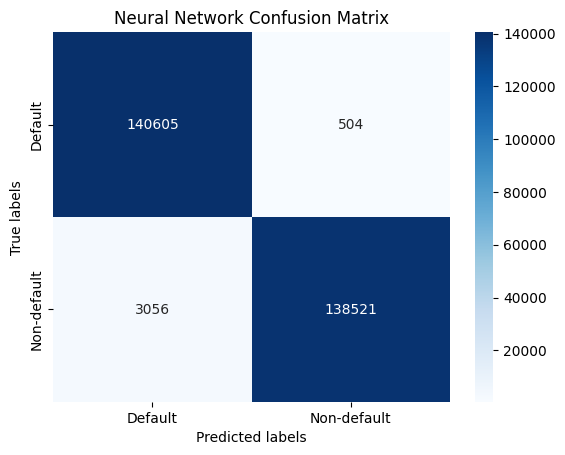

In [42]:
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix_sum, annot=True, cmap='Blues', fmt='d')

# Set labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Neural Network Confusion Matrix')

tick_labels = ['Default', 'Non-default']
tick_positions = [0, 1]
plt.xticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)
plt.yticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)

# Show the plot
plt.show()

# plt.tight_layout()
# fig.savefig(r"../results/neural-network-cm-1.04.png")